# NNIA 18/19 Project 3:  Regularization and Data Augmentation

## Deadline: 26. January 2019, 23:59

## 1. Dropout$~$ (9 points)

In the following exercise you would use an already implemented **feed-forward network** using **only** Numpy. We will add here the dropout regualrization technique that you learned about in the lecture.

The goal is to implement dropout for layer 2 in the provided three-layers network.

Before you start, here is a simple introduction about dropout. Dropout is a regualization technique that performs random dropping of neurons with a certain probability at each mini-batch in training time. Introducing such randomness or noise at training is helpful to make the network not fully dependent on the training set and therefore, it could generalize better to other unseen data. 

A simple dropout implementation creates a mask ($r^{(l)}_j$) for every neuron $j$ of the hidden layer $l$ by drawing from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability $p$, where $p$ is the probability of keeping neurons. You can think of it as a coin flip for each neuron with a probability $p$ to determine if that neuron will be kept or not. For more information, refer to section 7.12 in Deep Learning book.

$$ r^{(l)}_j \sim Bernoulli(p) $$
This mask is then applied to the hidden layer output ($h^{(l)}$) to obtain the regularized hidden layer activation $\hat{h}^{(l)}$
$$ \hat{h}^{(l)} = r^{(l)} * h^{(l)}$$
However, such an implementation requires the layer to be multiplied by the dropout coefficient $p$ at evaluation time to balance the larger number of active units during testing.
$$ \hat{h}^{(l)} = p * h^{(l)}$$
Such an implementation requires the code to switch between different code blocks for forward-pass evaluation during training and testing. Hence, a smoother way to implement dropout is to use ***inverted dropout*** where the mask generated at the training is multiplied by the inverse of the dropout coefficient.
$$ r^{(l)}_j \sim Bernoulli(p) * \frac{1}{p}$$
This scheme allows the scaling to be learned during training and hence, no switching between code blocks is required. The idea of using inverted dropout is to provide a form of normalization; when dropping out neurons during training, we are now giving the network less neurons that what it will have in the test time. So, dividing by the keep_probs is done to scale the training so that we will not need to do anything in test time. 

a) The following code implements a simple one-hiddien-layer neural network similar to what you have done in project 2. Update this code to implement inverted dropout for a hidden layer size of 50 neurons (sections to be updated are marked with TODO). Make sure to handle forward and backward passes and handle inference time as well (5.5 points)


In [0]:
# saving logs

from google.colab import drive
drive.mount('/content/gdrive')
import json

path='/content/gdrive/My Drive/'

def write_logs(data,f):
  fname=path+f
  with open(fname,'w') as fh:
    json.dump(data,fh)

def read_logs(f):
  fname=path+f
  with open(fname,'r') as fh:
    data=json.load(fh)
  return data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


- Load **Fashion-MNIST** dataset and normalized it.

In [0]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

xTest = X_test[0]


4423680/4422102 [==============================] - 0s 0us/step


In [0]:
print(X_trainval.shape)

(60000, 28, 28)


In [0]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


- Normalize the data. Subtract the mean and divide by the standard deviation.

In [0]:
def data_normalization(X_trainval, X_test):
    feature_means = X_trainval.mean(axis = 0)
    feature_std = np.std(X_trainval, axis = 0)
    X_trainval_normalized = (X_trainval - feature_means) / feature_std
    X_test_normalized = (X_test - feature_means) / feature_std
    return X_trainval_normalized, X_test_normalized

In [0]:
# The normalization should be done on X_train and X_test
# and normalized data should have the exactly same shape as the original data matrix.

X_trainval, X_test = data_normalization(X_trainval, X_test)
print(X_trainval.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [0]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from __future__ import division


class MLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        
    n_hidden : int (default: 30)
        Number of hidden units.
        
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
        
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
        
    epochs : int (default: 500)
        Number of passes over the training set.
        
    eta : float (default: 0.001)
        Learning rate.
        
    alpha : float (default: 0.0)
        Momentum constant.
        
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
        
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
    
    dropout : float (default: 1.0, no dropout)
        Set the dropout coefficient (keep probability of neurons)

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

      
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=50, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=1, dropout = 1.0):

        self.n_output = n_output
        self.r = np.random.RandomState(random_state)
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        # The dropout variable is the keep probability for neurons.
        # Initialize the class variable "dropout" like other variables above. Also, initialize a variable mask to None.
        # This will allow sharing dropout information during forward and backward pass of the neural networks. Note 
        # that the __init__ function has already been modified to include dropout coefficient as an argument. (0.5 points)
        
        #TODO: Implement
        self.dropout = dropout
        self.mask = None

    def _encode_labels(self, y, k):    
        """Encode the labels using one-hot representation

        Parameters
        ------------
        y : y represents target values.

        Returns
        -----------
        onehot array

        """
       
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        w1 = self.r.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = self.r.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        
        return X_new

    def _feedforward(self, X, w1, w2, if_train=True):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.
        if_train: if this is during training

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        
        # Implement inverted dropout using the class variables dropout and activation variable (a2) for the forward
        # pass for the second hidden layer below. To create the mask you will have to use self.r.binomial for 
        # generating the bernoulli distribution. The mask created here needs to be stored in the appropriate mask
        # variable defined in the __init__ function for further use by the backward pass.
        # Make sure to handle the inference case (2.5 points)
        
        # TODO: Implement
        if if_train:
          self.mask = self.r.binomial(1,self.dropout,size=a2.shape)/self.dropout
          a2 = a2*self.mask
        
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.
        """
           
        np.seterr(divide='ignore')
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        
        term1[np.isneginf(term1)] = 0
        term2[np.isneginf(term2)] = 0
        
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        
        return cost/ y_enc.shape[1]
        
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.
        """
        
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        
        # Implement dropout for the backward pass, use class variables for mask and dropout for this task (2.5 points)
        
        # TODO: Implement
        sigma2 = sigma2*self.mask
        
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])
        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        #TODO: Call the feedforward to get a1, z2, a2, z3, a3 (0.5 point)
        a1, z2, a2, z3, a3 = self._feedforward(X,self.w1,self.w2)
        y_pred = np.argmax(z3, axis=0)
        
        return y_pred

    def fit(self, X, y, print_progress=False, validation_freq=0, X_val=None, y_val=None, data_augmentation=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.
        validation_freq=0, X_val=None, y_val=None: If provided, perform validation check for early stopping (Task 2)
        data_augmentation: bool (default: False)
            If true, perform data augmentation (Task 3)

        Returns:
        ----------
        self

        """
        
          
        
        self.cost_ = []
        train_err = []
        test_err = []
        train_err_earlystopping = []
        test_err_earlystopping = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            
            for idx in mini:
              
              #print('idx mini')
              #mini_list = []
             #print(len(idx))
              if data_augmentation == True:
                
#                 mini_list = []  
#                 for i in idx:
#                   mini_list.append(np.reshape(X_data[i],(28,28)))
#                 print(len(mini_list))
#                 print(X_data[idx].shape)
#                 X_data[idx] = online_augmentation(mini_list)
#                 X_data[idx] = np.reshape(X_data[idx], (X_data[idx].shape[0],  X_data[idx].shape[1] *  X_data[idx].shape[2]))
                  
                mini_list = np.zeros(shape=(len(idx),28,28))
                for i in idx:
                  mini_list[(i%len(idx))]=(np.reshape(X_data[i],(28,28)))
             
                aug_batch = online_augmentation(mini_list)
#                 print(mini_list.shape,aug_batch.shape)
                aug_batch= aug_batch.reshape(aug_batch.shape[0],-1)
                X_data[idx] = aug_batch
                
                
                #online_augmentation(mini_list)
                
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)
               
                

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                    a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
#                 print('Successfully augmented')
              
               
                # feedforward
              else:
                
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)
               
                

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
                
            train_err.append(cost)
            
              
            y_encode = self._encode_labels(y_val, self.n_output)
            
            a1, z2, a2, z3, a3 = self._feedforward(X_val,
                                                       self.w1,
                                                       self.w2)
            test_cost = self._get_cost(y_enc=y_encode,
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
            test_err.append(test_cost)
            
           # m = X_test.shape[0]
            
              

        if (validation_freq > 0 and  X_val is not None and  y_val is not None):
          #print(validation_freq)
          for i in range(len(train_err)):
            
            if ((i+1)%validation_freq == 0):
              train_err_earlystopping.append(train_err[i])
              test_err_earlystopping.append(test_err[i])
          return self, train_err_earlystopping, test_err_earlystopping
        else: 
          return self, train_err, test_err


---
**Points:** $0.0$ of $6$
**Comments:** None

---

b) Next we are goining to plot the variation of training and test accuracies for variying keep probability values ($p$) denoted by np.arange(0.3, 1.0, 0.3). Explain your findings, how do you observe the effect of keep probability values on accuracies. (3 points)



In [0]:
#TODO: for each dropout value, create a class instance and call the fit function and print the training and test accuracy in percentage for each value of dropout.

#Initialize the class for each dropout value as follows:

"""
nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=500, 
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = dropout)
"""

keep_prob=np.arange(0.3,1.0,0.3)

train_bar=[]
test_bar=[]

train_loss_bar=[]
validation_loss_bar=[]
for i in range(len(keep_prob)):
  nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=500, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = keep_prob[i])
  

  _, train_loss,validation_loss = nn.fit(X_trainval, Y_trainval, print_progress=True, X_val= X_test, y_val=Y_test)

  
  train_bar.append(train_loss[-1])
  test_bar.append(validation_loss[-1])
  Y_train_pred = nn.predict(X_trainval)

  train_acc = np.sum(Y_trainval == Y_train_pred, axis=0) / X_trainval.shape[0]
  train_loss_bar.append(1-train_acc)
  

  print('Training accuracy for dropout %.2f: %.2f%%' % (keep_prob[i],train_acc * 100))

  Y_test_pred = nn.predict(X_test)

  validation_acc = np.sum(Y_test == Y_test_pred, axis=0) / X_test.shape[0]
  validation_loss_bar.append(1-validation_acc)

  print('Test accuracy for dropout %.2f: %.2f%%' % (keep_prob[i],validation_acc * 100))





Epoch: 1/500

Epoch: 2/500

Epoch: 3/500

Epoch: 4/500

Epoch: 5/500

Epoch: 6/500

Epoch: 7/500

Epoch: 8/500

Epoch: 9/500

Epoch: 10/500

Epoch: 11/500

Epoch: 12/500

Epoch: 13/500

Epoch: 14/500

Epoch: 15/500

Epoch: 16/500

Epoch: 17/500

Epoch: 18/500

Epoch: 19/500

Epoch: 20/500

Epoch: 21/500

Epoch: 22/500

Epoch: 23/500

Epoch: 24/500

Epoch: 25/500

Epoch: 26/500

Epoch: 27/500

Epoch: 28/500

Epoch: 29/500

Epoch: 30/500

Epoch: 31/500

Epoch: 32/500

Epoch: 33/500

Epoch: 34/500

Epoch: 35/500

Epoch: 36/500

Epoch: 37/500

Epoch: 38/500

Epoch: 39/500

Epoch: 40/500

Epoch: 41/500

Epoch: 42/500

Epoch: 43/500

Epoch: 44/500

Epoch: 45/500

Epoch: 46/500

Epoch: 47/500

Epoch: 48/500

Epoch: 49/500

Epoch: 50/500

Epoch: 51/500

Epoch: 52/500

Epoch: 53/500

Epoch: 54/500

Epoch: 55/500

Epoch: 56/500

Epoch: 57/500

Epoch: 58/500

Epoch: 59/500

Epoch: 60/500

Epoch: 61/500

Epoch: 62/500

Epoch: 63/500

Epoch: 64/500

Epoch: 65/500

Epoch: 66/500

Epoch: 67/500

Epo

In [0]:
write_logs(train_loss,'train_dropout.json')
write_logs(validation_loss,'val_dropout.json')
write_logs(train_loss_bar,'train_loss_dropout.json')
write_logs(validation_loss_bar,'val_loss_dropout.json')

train_loss_bar = read_logs('train_loss_dropout.json')
validation_loss_bar = read_logs('val_loss_dropout.json')



[1.122773764784917, 0.6936858694506244, 0.49748887077006354] : [1.346199686652505, 0.9203078241944904, 0.8518144241901735]


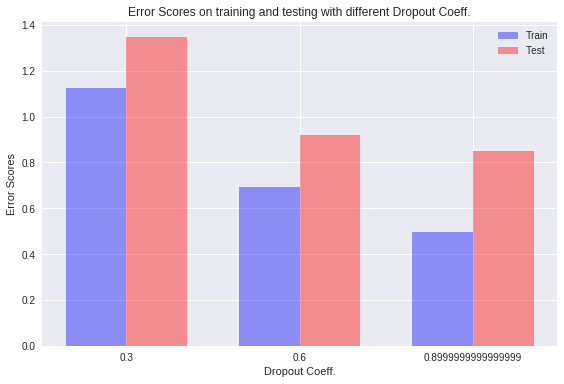

In [0]:
print(train_bar,":",test_bar)  
#test_loss = nn.cost_

#plot
fig, ax = plt.subplots()
index = np.arange(len(train_bar))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, train_bar, bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Train')

rects2 = ax.bar(index + bar_width, test_bar, bar_width,
                alpha=opacity, color='r',
                 error_kw=error_config,
                label='Test')

ax.set_xlabel('Dropout Coeff.')
ax.set_ylabel('Error Scores')
ax.set_title('Error Scores on training and testing with different Dropout Coeff.')
ax.set_xticks(index + bar_width / 2)
labels=list(keep_prob)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

[0.2270833333333333, 0.13070000000000004, 0.09004999999999996] : [0.24719999999999998, 0.17000000000000004, 0.15300000000000002]


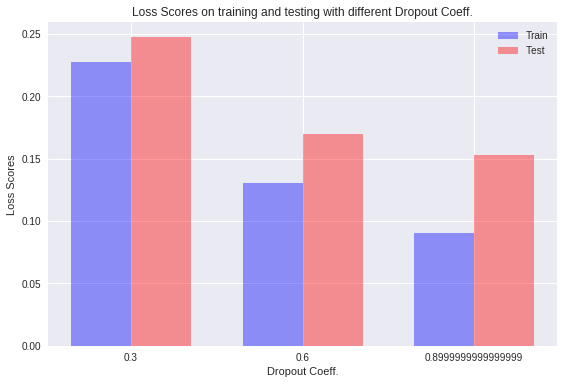

In [0]:
print(train_loss_bar,":",validation_loss_bar)  
#test_loss = nn.cost_

#plot
fig, ax = plt.subplots()
index = np.arange(len(train_loss_bar))
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, train_loss_bar, bar_width,
                alpha=opacity, color='b',
                error_kw=error_config,
                label='Train')

rects2 = ax.bar(index + bar_width, validation_loss_bar, bar_width,
                alpha=opacity, color='r',
                 error_kw=error_config,
                label='Test')

ax.set_xlabel('Dropout Coeff.')
ax.set_ylabel('Loss Scores')
ax.set_title('Loss Scores on training and testing with different Dropout Coeff.')
ax.set_xticks(index + bar_width / 2)
labels=list(keep_prob)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

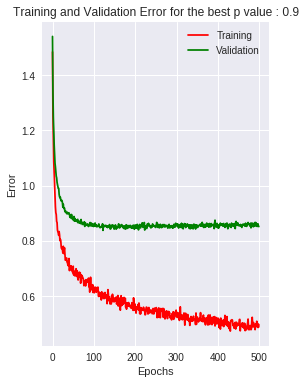

In [0]:

#for the best p-value (Clearly, dropout coeff. 0.9 has the best performance)
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values

# TODO: Implement
plt.subplot(1, 2, 1)
plt.plot(train_loss,'r')
plt.plot(validation_loss,'g')

#plt.ylim([0,3000])
plt.title('Training and Validation Error for the best p value : 0.9')
plt.ylabel('Error')
plt.xlabel('Epochs')

plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $3$
**Comments:** None

---

Ans : **From the results, we therefore infer that the model performance increases with the keep_probs i.e. more the keep_probs, better is the accuracy and less is the error rate. Since, with higher value of keep_probs, the number of neurons being dropped is less i.e keep_probs =1 implies no dropout and vice-versa. With kep_probs of 0.9 i.e. when we drop 10% of the neurons in the hidden layer, the model has sufficient units to generalize the structure/feature of the data. As the neurons decreases, the model's performance of learning the features decreases and hence we see a better performance with 0.9  **

## 2. Early Stopping$~$ (9 points)

For reference see Wikipedia page: https://en.wikipedia.org/wiki/Early_stopping, and also refer to section 7.8 in Deep Learning book.

*Early stopping* is a form of regualrization that avoids overfitting by using the validation set error as an indication on when to stop the training before the validation set error starts increasing again. 

Goal: To study how increasing neurons of a neural network (model complexity) affects the Early Stopping threshold.

a) First, update the feedforward neural network code from Task 1 to calculate training and validation error at every 100 iterations (also known as validation frequency) of the training scheme. For this update, you will modify the fit function. The signature of the train function in task 1 include the following default values: (validation_freq=0, X_val=None, y_val=None), notice that these arguments need to be provided to calculate the validation error (of the validation set) at every 100 iterations (validation frequency).
Overload the fit function in task 1 to perform the early stopping if these arguments are provided (for information about function overloading, refer to: https://stackabuse.com/overloading-functions-and-operators-in-python. 
The fit function should return train_err and test_err for each step in validation frequency (that are initialized as empty). (3 points)

In [0]:
nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=500, #to be changed to 500
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1
        )
_, train_loss,validation_loss = nn.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=100,X_val= X_test, y_val=Y_test)



Epoch: 1/400

Epoch: 2/400

Epoch: 3/400

Epoch: 4/400

Epoch: 5/400

Epoch: 6/400

Epoch: 7/400

Epoch: 8/400

Epoch: 9/400

Epoch: 10/400

Epoch: 11/400

Epoch: 12/400

Epoch: 13/400

Epoch: 14/400

Epoch: 15/400

Epoch: 16/400

Epoch: 17/400

Epoch: 18/400

Epoch: 19/400

Epoch: 20/400

Epoch: 21/400

Epoch: 22/400

Epoch: 23/400

Epoch: 24/400

Epoch: 25/400

Epoch: 26/400

Epoch: 27/400

Epoch: 28/400

Epoch: 29/400

Epoch: 30/400

Epoch: 31/400

Epoch: 32/400

Epoch: 33/400

Epoch: 34/400

Epoch: 35/400

Epoch: 36/400

Epoch: 37/400

Epoch: 38/400

Epoch: 39/400

Epoch: 40/400

Epoch: 41/400

Epoch: 42/400

Epoch: 43/400

Epoch: 44/400

Epoch: 45/400

Epoch: 46/400

Epoch: 47/400

Epoch: 48/400

Epoch: 49/400

Epoch: 50/400

Epoch: 51/400

Epoch: 52/400

Epoch: 53/400

Epoch: 54/400

Epoch: 55/400

Epoch: 56/400

Epoch: 57/400

Epoch: 58/400

Epoch: 59/400

Epoch: 60/400

Epoch: 61/400

Epoch: 62/400

Epoch: 63/400

Epoch: 64/400

Epoch: 65/400

Epoch: 66/400

Epoch: 67/400

Epo

In [0]:
print(len(train_loss),",",len(validation_loss))

4 , 4


---
**Points:** $0.0$ of $3.0$
**Comments:** None

---

b) Use this code for a different number of neurons (50, 200) and plot the variation of training and validation error for every 100th iteration up to 700 iterations. Label the axes and legends appropriately in the plots. 
Use the same X_trainval, Y_trainval, X_test, Y_test from task 1.
Use Keep probability of dropout to 1 as in default values (no dropout). 

**Note:** to calculate the validation error we use the test set as a proxy validation set. In general, the correct way to do that would be to keep a separate set for validation and test, the reason for that is that any hyperparameter should be selected based on the validation set, and the test set should be kept for testing the model as unseen data only. Please keep in mind that here we are doing a simplification only for the assignment purpose. 

(3 points)

In [0]:
#TODO: create two classes instances and fit two times with different neurons number

#TODO: Plots for training and test errors for the 2 models 

In [0]:
#2 Instances

#with 50
nn1 = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=700, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1)

#with 200
nn2 = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=200, 
             l2=0.0, 
             l1=0.0, 
             epochs=700, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1)

_, train_loss1,validation_loss1 = nn1.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=100,X_val= X_test, y_val=Y_test)
_, train_loss2,validation_loss2 = nn2.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=100,X_val= X_test, y_val=Y_test)



Epoch: 1/700

Epoch: 2/700

Epoch: 3/700

Epoch: 4/700

Epoch: 5/700

Epoch: 6/700

Epoch: 7/700

Epoch: 8/700

Epoch: 9/700

Epoch: 10/700

Epoch: 11/700

Epoch: 12/700

Epoch: 13/700

Epoch: 14/700

Epoch: 15/700

Epoch: 16/700

Epoch: 17/700

Epoch: 18/700

Epoch: 19/700

Epoch: 20/700

Epoch: 21/700

Epoch: 22/700

Epoch: 23/700

Epoch: 24/700

Epoch: 25/700

Epoch: 26/700

Epoch: 27/700

Epoch: 28/700

Epoch: 29/700

Epoch: 30/700

Epoch: 31/700

Epoch: 32/700

Epoch: 33/700

Epoch: 34/700

Epoch: 35/700

Epoch: 36/700

Epoch: 37/700

Epoch: 38/700

Epoch: 39/700

Epoch: 40/700

Epoch: 41/700

Epoch: 42/700

Epoch: 43/700

Epoch: 44/700

Epoch: 45/700

Epoch: 46/700

Epoch: 47/700

Epoch: 48/700

Epoch: 49/700

Epoch: 50/700

Epoch: 51/700

Epoch: 52/700

Epoch: 53/700

Epoch: 54/700

Epoch: 55/700

Epoch: 56/700

Epoch: 57/700

Epoch: 58/700

Epoch: 59/700

Epoch: 60/700

Epoch: 61/700

Epoch: 62/700

Epoch: 63/700

Epoch: 64/700

Epoch: 65/700

Epoch: 66/700

Epoch: 67/700

Epo

In [0]:
write_logs(train_loss1,'train_earlystop1.json')
write_logs(validation_loss1,'val_earlystop1.json')
write_logs(train_loss2,'train_earlystop2.json')
write_logs(validation_loss2,'val_earlystop2.json')

In [0]:
#train_loss1 = read_logs('train_earlystop1.json')
print(len(train_loss2))
print(train_loss[30])

7
0.7527132011251139


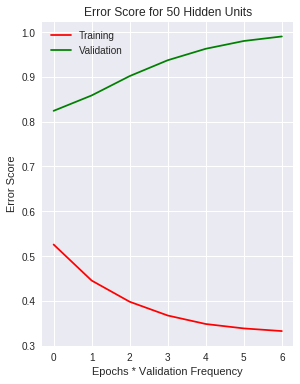

In [0]:
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values

# TODO: Implement
#Training Plot

plt.subplot(1, 2, 1)
plt.plot(train_loss1,'r')
plt.plot(validation_loss1,'g')

#plt.ylim([0,3000])
plt.title('Error Score for 50 Hidden Units')
plt.ylabel('Error Score')
plt.xlabel('Epochs * Validation Frequency')

plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()

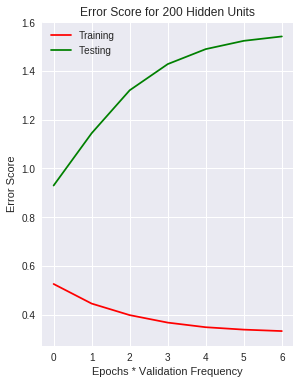

In [0]:
# Validation Plot

plt.subplot(1, 2, 1)
plt.plot(train_loss1,'r')
plt.plot(validation_loss2,'g')

#plt.ylim([0,3000])
plt.title('Error Score for 200 Hidden Units')
plt.ylabel('Error Score')
plt.xlabel('Epochs * Validation Frequency')

plt.gca().legend(('Training','Testing'))

plt.tight_layout()
plt.show()

In [0]:
#comment : since we couldn't infer the ideal stopping epoch using validation_freq = 100, we run an experiment with a total of 100 epochs and validation_freq = 2 for better inference. 

#with 50
nn1 = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=200, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1)
_, _train_loss1_,_validation_loss1_ = nn1.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=2,X_val= X_test, y_val=Y_test)


Epoch: 1/200

Epoch: 2/200

Epoch: 3/200

Epoch: 4/200

Epoch: 5/200

Epoch: 6/200

Epoch: 7/200

Epoch: 8/200

Epoch: 9/200

Epoch: 10/200

Epoch: 11/200

Epoch: 12/200

Epoch: 13/200

Epoch: 14/200

Epoch: 15/200

Epoch: 16/200

Epoch: 17/200

Epoch: 18/200

Epoch: 19/200

Epoch: 20/200

Epoch: 21/200

Epoch: 22/200

Epoch: 23/200

Epoch: 24/200

Epoch: 25/200

Epoch: 26/200

Epoch: 27/200

Epoch: 28/200

Epoch: 29/200

Epoch: 30/200

Epoch: 31/200

Epoch: 32/200

Epoch: 33/200

Epoch: 34/200

Epoch: 35/200

Epoch: 36/200

Epoch: 37/200

Epoch: 38/200

Epoch: 39/200

Epoch: 40/200

Epoch: 41/200

Epoch: 42/200

Epoch: 43/200

Epoch: 44/200

Epoch: 45/200

Epoch: 46/200

Epoch: 47/200

Epoch: 48/200

Epoch: 49/200

Epoch: 50/200

Epoch: 51/200

Epoch: 52/200

Epoch: 53/200

Epoch: 54/200

Epoch: 55/200

Epoch: 56/200

Epoch: 57/200

Epoch: 58/200

Epoch: 59/200

Epoch: 60/200

Epoch: 61/200

Epoch: 62/200

Epoch: 63/200

Epoch: 64/200

Epoch: 65/200

Epoch: 66/200

Epoch: 67/200

Epo

In [0]:
#comment : since we couldn't infer the ideal stopping epoch (convergence point was not visible in the plot) using validation_freq = 100, we run an experiment with a total of 100 epochs and validation_freq = 2 for better inference. 

#with 50
nn1 = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=200, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1)

#with 200
nn2 = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=200, 
             l2=0.0, 
             l1=0.0, 
             epochs=100, #to be changed to 400
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = 1)

_, _train_loss1,_validation_loss1 = nn1.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=2,X_val= X_test, y_val=Y_test)
_, _train_loss2,_validation_loss2 = nn2.fit(X_trainval, Y_trainval, print_progress=True, validation_freq=2,X_val= X_test, y_val=Y_test)



Epoch: 1/100

Epoch: 2/100

Epoch: 3/100

Epoch: 4/100

Epoch: 5/100

Epoch: 6/100

Epoch: 7/100

Epoch: 8/100

Epoch: 9/100

Epoch: 10/100

Epoch: 11/100

Epoch: 12/100

Epoch: 13/100

Epoch: 14/100

Epoch: 15/100

Epoch: 16/100

Epoch: 17/100

Epoch: 18/100

Epoch: 19/100

Epoch: 20/100

Epoch: 21/100

Epoch: 22/100

Epoch: 23/100

Epoch: 24/100

Epoch: 25/100

Epoch: 26/100

Epoch: 27/100

Epoch: 28/100

Epoch: 29/100

Epoch: 30/100

Epoch: 31/100

Epoch: 32/100

Epoch: 33/100

Epoch: 34/100

Epoch: 35/100

Epoch: 36/100

Epoch: 37/100

Epoch: 38/100

Epoch: 39/100

Epoch: 40/100

Epoch: 41/100

Epoch: 42/100

Epoch: 43/100

Epoch: 44/100

Epoch: 45/100

Epoch: 46/100

Epoch: 47/100

Epoch: 48/100

Epoch: 49/100

Epoch: 50/100

Epoch: 51/100

Epoch: 52/100

Epoch: 53/100

Epoch: 54/100

Epoch: 55/100

Epoch: 56/100

Epoch: 57/100

Epoch: 58/100

Epoch: 59/100

Epoch: 60/100

Epoch: 61/100

Epoch: 62/100

Epoch: 63/100

Epoch: 64/100

Epoch: 65/100

Epoch: 66/100

Epoch: 67/100

Epo

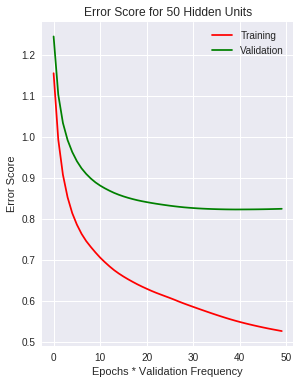

In [0]:
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values

# TODO: Implement
#Training Plot

plt.subplot(1, 2, 1)
plt.plot(_train_loss1,'r')
plt.plot(_validation_loss1,'g')

#plt.ylim([0,3000])
plt.title('Error Score for 50 Hidden Units')
plt.ylabel('Error Score')
plt.xlabel('Epochs * Validation Frequency')

plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()

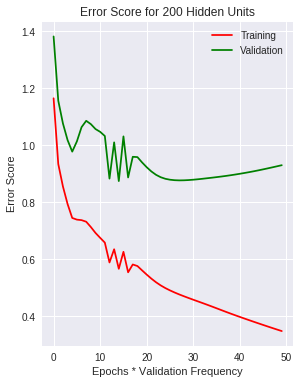

In [0]:
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values

# TODO: Implement
#Training Plot

plt.subplot(1, 2, 1)
plt.plot(_train_loss2,'r')
plt.plot(_validation_loss2,'g')

#plt.ylim([0,3000])
plt.title('Error Score for 200 Hidden Units')
plt.ylabel('Error Score')
plt.xlabel('Epochs * Validation Frequency')

plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()

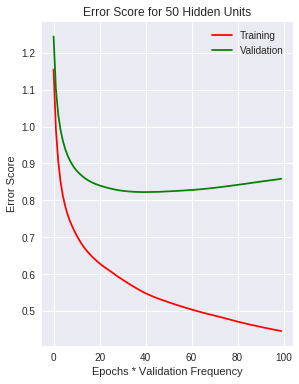

In [0]:
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values

# TODO: Implement
#Training Plot

plt.subplot(1, 2, 1)
plt.plot(_train_loss1_,'r')
plt.plot(_validation_loss1_,'g')

#plt.ylim([0,3000])
plt.title('Error Score for 50 Hidden Units')
plt.ylabel('Error Score')
plt.xlabel('Epochs * Validation Frequency')


plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()


---
**Points:** $0.0$ of $3.0$
**Comments:** None

---

c) Using these plots, make suggestions for an early stopping criteria for each hidden layer size. (1 point)

Answer: **For 50 Hidden Units, stopping epoch can be between 30-35. For network with 200 hidden units, a good stopping point would be 25 epochs**

d) As the number of neurons are increased, you will observe differences in the early stopping criteria for each hidden layer size. Why do you observe such differences? (1 point)

Answer: **With increased model complexity(size of hidden units), the model converges faster (w.r.t validation error's mimima)beacuse the hidden layer with more neurons learns the struture of the data/features faster.** 

e) How early stopping can be similar to L2 regularization? (1 point)

Answer: **Both the techniques can be used to overcome the problem of over-fitting. L2 reg. contrains the weights and therefore with less degree of freedom, it becomes difficult to overfit the data and with early stopping we find the ideal stopping point when the validation error reaches a minimum.** 

---
**Points:** $0.0$ of $3.0$
**Comments:** None

---

## 3. Data Augmentation$~$ (12 points)

While the performance of neural networks can significantly increase with increasing training data size, collecting a large dataset is hard and needs a lot of work in annotation. Therefore, data augmentation is a widley used technique in machine learning to artificially increase your training set size. In case of images, data augmentation methods can be scaling, rotations, cropping, or mirroring. In this exercise, we will get familiar with some of these techniques and apply them on the MNIST fashion dataset. 

For additional reading, you can refer to the following paper (also known as AlexNet) which is one of the papers that revolutionized neural networks applications in image classification and has used data augmentation to increase training data size:

Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012 (http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

**Additional note:** These types of augmentation methods usually work best with a type of neural networks called *Convolutional Neural Networks (CNNs)* becuase these networks can learn features that are invariant under transformations (Wikipedia: https://en.wikipedia.org/wiki/Convolutional_neural_network). However, we will use it here with a simple fully connected network to learn the concept. 


Note: for all the next questions, the argument of the function is a 2d Numpy array of 28x28 (one single MNIST example before reshaping)

a) One common way of data augmentation in images is flipping, here, we will flip the images across the vertical axis. In the following, implement a function that takes an input image and perform vertical flipping. Call your function with a simple  input image and display both the original and transformed images. (0.5 point)


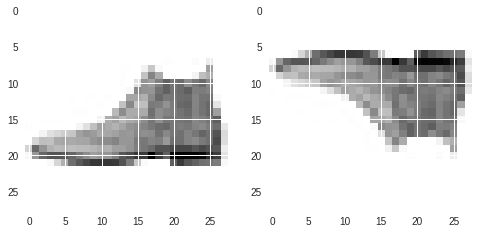

In [0]:
#TODO: Implement vertical flipping. Use Numpy
import matplotlib.pyplot as plt
def flip_img(one_input_image):
    flipped_img= np.flip(one_input_image,axis=0)
    return flipped_img
  
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xTest)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(flip_img(xTest))


b) Another common way is image rotation, here, we will flip the images 90 degrees clock wise. In the following, implement a function that takes a one input image and perform rotation. Call your function with a simple one input image and display both the original and transformed images (0.5 point). 

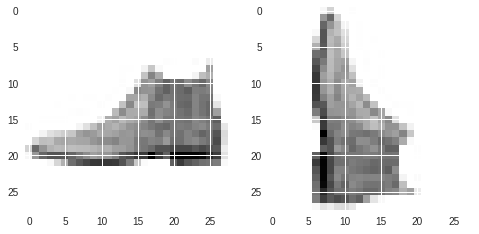

In [0]:
#TODO: Implement image rotation by 90 degrees clockwise using Numpy
def rotate_img(one_input_image):
    rotated_img= np.rot90(one_input_image, axes=(1,0))
    return rotated_img
  
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xTest)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rotate_img(xTest))


c) Perform a function that scales one image by a given scale ratio (>1 to work as a zoom-out), make sure that the scaled image has the same size. Call your function with a simple one input image and a scale ratio of 2, and display both the original and transformed images (0.5).


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


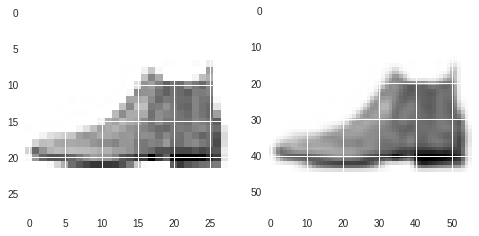

In [0]:
#TODO: Implement image scaling
#For this, you can use an image processing library such as: https://scikit-image.org/ (install if needed)
!pip install scikit-image
from skimage import transform
def scale_img(one_input_image, scale_ratio):
    scaled_img =transform.rescale(one_input_image,scale_ratio)
    return scaled_img

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xTest)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(scale_img(xTest,2))


d) Another used method is translation, here, we want to translate our image to the right or the left only, make sure to do zero padding as needed after the translation. Call your function twice, once with a simple one input image and a translation of 5 pixels to the right, and once with the same input image but with a translation of 5 pixels to the left (1 point).  

28
(28, 5)


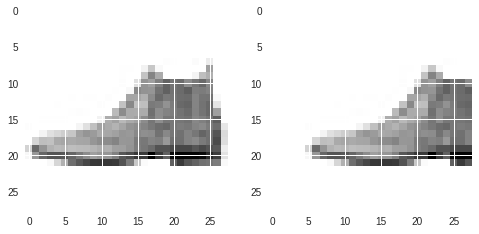

In [0]:
#TODO: Implement image translation. Use Numpy
def translate_img(one_input_image, right_or_left_flag, shift_pixels):
    #translated_img = np.zeros(one_input_image.shape())
    print(one_input_image.shape[0])
   # padding = np.zeros((28,5))
    padding = np.zeros((one_input_image.shape[0],shift_pixels))
    print(padding.shape)
    if right_or_left_flag==1:
      translated_img = np.concatenate((padding,one_input_image),1)
      translated_img = np.delete(translated_img, np.s_[translated_img.shape[1]-shift_pixels:translated_img.shape[1]], axis=1)
      
        #translated_img(:,(:)+5)+= one_input_image
    else:
      translated_img = np.concatenate((one_input_image,padding),1)
      translated_img = np.delete(translated_img, np.s_[0:shift_pixels], axis=1)      
      
        #translated_img(:,(:)-5)+= one_input_image
    return translated_img
  
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xTest)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(translate_img(xTest,1,5))

e) Another way of augmentation is introducing random noise to your training set. Implement a function that takes an input image and adds Gaussian noise of mean 0 and std 0.2 to the original image (0.5 points).

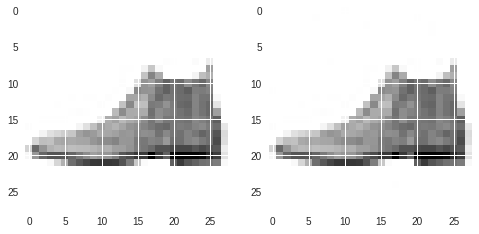

In [0]:
#TODO: Implement adding Gaussian noise. Use Numpy
def distort_img(one_input_image):
    row,col=one_input_image.shape
    gauss = np.random.normal(0,0.2,(row,col))
    distorted_img = one_input_image + gauss.reshape(row,col)
    return distorted_img
  

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(xTest)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(distort_img(xTest))


f) What are other advantages of data augmentation beside increasing data size? Elaborate on in which cases each type of data augmentation mentioned above could be effective (scaling, translation, etc.) (1.5 point)

**Answer**: The second advantage of data augmentation is that it prevents the model from overfitting to the training data. This results in a model which is more flexible, robust, and has a higher generalisation capacity.  Thus, data augmentation can improve model performance on the unseen data.

The effectiveness of augmentation techniques depends on the dataset:
* vertical flipping: useful if the object can occur upside down
* rotation: useful if the object can occur in different orientations
* scaling: when the object size can vary
* translation: when the location of the object in the image can vary
* Gaussian noise: if the data is likely to contain noise, example, from camera artifacts

g) There are two ways of performing data augmentation. One is offline augmentation where we apply these augmentations before the training and increase the training set size by a factor (that is usually done for small datasets), another way is to apply these augmentations for each mini-batch online during the training (used for larger datasets). We will use here online augmentation in order to not extensively increase the required computation time.

1. Perform a function that takes an input of mini-batch images, and for each image in these images, decide if to perform augmentation or not based on a random flip. 

2. If augmentation is performed, decide which type of augmentation to use based on another random variable (options: flip, scale, rotate, translate, Gaussian distortion). 

3. For scaling, generate a random scaling factor (in range from 1 to 2). 

4. For translation, decide randomly based on another variable if translation is done to left or right, and generate a random transition between 5 and 10 pixels.

Note that the number of observation in the batch will be the same.

(3.5 points)

In [0]:
# #TODO: Implement online_augmentation
# import random
# #augmented_batch=[]
# def online_augmentation(batch_images):
#   augmented_batch=[]
#   print(len(batch_images))
#   for image in batch_images:
#     _augmented = random.sample(range(0,2),1)
    
#     if _augmented == 0:
#       type_augmented = random.sample(range(0,5),1)
      
#       if type_augmented == 0:
#         augmented_batch.append(flip_img(image))
#       if type_augmented == 1:
#         size = random.sample(range(1,3),2)
#         augmented_batch.append(scale_img(image,size))
#       if type_augmented == 2:
#         augmented_batch.append(distort_img(image))
#       if type_augmented == 3: #implement the translate_img()
#         direction = random.sample(range(0,2),1)
#         shift = random.sample(range(5,11),1)
#         augmented_batch.append(translate_img(image,direction,shift))
#       else :
#         augmented_batch.append(rotate_img(image))
        
#     else:
#       augmented_batch.append(image)
          
#    #print(len(augmented_)) 
#   print("aug",len(augmented_batch))
#   return augmented_batch
    

In [0]:
#TODO: Implement online_augmentation
import random
#augmented_batch=[]
def online_augmentation(batch_images):
  augmented_batch=np.copy(batch_images)
#   print(batch_images.shape)
  for i,image in enumerate(batch_images):
    _augmented = random.sample(range(0,2),1)
#     print(_augmented)
#     print(image.shape)
    
    if _augmented[0] == 0:
      type_augmented = random.sample(range(0,5),1)
#       print("augmenting")
      
      if type_augmented == 0:
        augmented_batch[i]=flip_img(image)
      elif type_augmented == 1:
        size = random.sample(range(1,3),2)
        augmented_batch[i]=scale_img(image,size)
      elif type_augmented == 2:
        augmented_batch[i]=distort_img(image)
      elif type_augmented == 3: #implement the translate_img()
        direction = random.sample(range(0,2),1)
        shift = random.sample(range(5,11),1)
        augmented_batch[i]=translate_img(image,direction,shift)
      else :
        augmented_batch[i]=rotate_img(image)
        
    
          
   #print(len(augmented_)) 
#   print("aug",augmented_batch.shape)
  return augmented_batch
    

h) Now use the function (online_augmentation) that you implemented in 7, to edit the (fit) function in the class in Task 1. 

Note: Use the same X_trainval, Y_trainval, X_test, Y_test from task 1. However, **reshape** the mini-batches to a 2d image shape before applying augmentation and after that reshape it again to the flatted version. The fit function has data_augmentation parameter (default: False), if true, data augmentation should be performed (without early stopping and dropout).

(1 point)


i) Create an instance of the MLP class with 50 neurons. Run the train function for 1500 epochs. Plot the train and test performance over epochs (1.5 point).

In [0]:
# 1500 epochs, don't re-run!

#TODO: create an instrance of the class
#TODO: run the fit function
#TODO: Plot the train and test performance over epochs
nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=1500, #to be changed to 1500
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1)
_, train_loss, val_loss= nn.fit(X_trainval, Y_trainval, print_progress=True, X_val= X_test, y_val=Y_test, data_augmentation=True)


Epoch: 1/1500

Epoch: 2/1500

Epoch: 3/1500

Epoch: 4/1500

Epoch: 5/1500

Epoch: 6/1500

Epoch: 7/1500

Epoch: 8/1500

Epoch: 9/1500

Epoch: 10/1500

Epoch: 11/1500

Epoch: 12/1500

Epoch: 13/1500

Epoch: 14/1500

Epoch: 15/1500

Epoch: 16/1500

Epoch: 17/1500

Epoch: 18/1500

Epoch: 19/1500

Epoch: 20/1500

Epoch: 21/1500

Epoch: 22/1500

Epoch: 23/1500

Epoch: 24/1500

Epoch: 25/1500

Epoch: 26/1500

Epoch: 27/1500

Epoch: 28/1500

Epoch: 29/1500

Epoch: 30/1500

Epoch: 31/1500

Epoch: 32/1500

Epoch: 33/1500

Epoch: 34/1500

Epoch: 35/1500

Epoch: 36/1500

Epoch: 37/1500

Epoch: 38/1500

Epoch: 39/1500

Epoch: 40/1500

Epoch: 41/1500

Epoch: 42/1500

Epoch: 43/1500

Epoch: 44/1500

Epoch: 45/1500

Epoch: 46/1500

Epoch: 47/1500

Epoch: 48/1500

Epoch: 49/1500

Epoch: 50/1500

Epoch: 51/1500

Epoch: 52/1500

Epoch: 53/1500

Epoch: 54/1500

Epoch: 55/1500

Epoch: 56/1500

Epoch: 57/1500

Epoch: 58/1500

Epoch: 59/1500

Epoch: 60/1500

Epoch: 61/1500

Epoch: 62/1500

Epoch: 63/1500



In [0]:
A = nn.predict(X_test)
train_aug = train_loss[-1]
test_aug = val_loss[-1]
print('Loss:')
print('  train: %.2f test: %.2f' % (train_aug,test_aug))

Y_train_pred = nn.predict(X_trainval)
train_acc = np.sum(Y_trainval == Y_train_pred, axis=0) / X_trainval.shape[0]

Y_test_pred = nn.predict(X_test)
test_acc = np.sum(Y_test == Y_test_pred, axis=0) / X_test.shape[0]
print('Accuracy:')
print('  train: %.2f%%, test: %.2f%%' % (train_acc*100 ,test_acc * 100))

Loss:
  train: 0.81 test: 1.08
Accuracy:
  train: 85.06%, test: 80.50%


In [0]:
# saving logs

from google.colab import drive
drive.mount('/content/gdrive')
import json

path='/content/gdrive/My Drive/'

def write_logs(data,f):
  fname=path+f
  with open(fname,'w') as fh:
    json.dump(data,fh)

def read_logs(f):
  fname=path+f
  with open(fname,'r') as fh:
    data=json.load(fh)
  return data



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#write
write_logs(train_loss,'train_aug.json')
write_logs(val_loss,'val_aug.json')

In [0]:
#read
train_loss = read_logs('train_aug.json')
validation_loss = read_logs('val_aug.json')

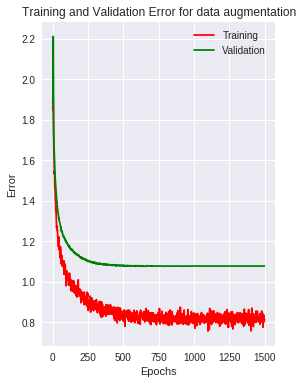

In [0]:
import matplotlib.pyplot as plt


# TODO: Implement
plt.subplot(1, 2, 1)
plt.plot(train_loss,'r')
plt.plot(validation_loss,'g')

#plt.ylim([0,3000])
plt.title('Training and Validation Error for data augmentation')
plt.ylabel('Error')
plt.xlabel('Epochs')

plt.gca().legend(('Training','Validation'))

plt.tight_layout()
plt.show()

j) Compare the performance of this version of the network with the vanilla-network that you have created in Task 2 (the early stopping without dropout). Do you see any performance increase. Explain why or why not. Based on this dataset, what form of data augmentation you think would be less effective than the others? (1.5 point)

**Answer:** Data augmentation did nor increase the model performance. After 1500 epochs, we obtain an accuracy of 80.5% on the test set. This is because of two reasons: first, online augmentation was not used to increase the training data, but instead, the minibatches were replace with augmented batches. Second, some techniques were not useful and led to more confusion for the model. For instance, vertical flipping on '6' would make the images look like those in the class '9'. 

For this dataset, vertical flipping and 90 degree rotation are not effective because the test set does not contain images obtained after applying these transformations. Also, as seen from adverserial machine learning literature, adding noise to images can change the predicted labels.

---
**Points:** $0.0$ of $12.0$
**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Put the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.**

- Soumya Ranjan Sahoo, 2576610
- Vinit Hegiste, 2576578
- Khusbhoo Mehra , 2576512

## Points: 0.0 of 30.0 points